## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import os

import datetime
from datetime import date, timedelta

#from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Earth continents

In [2]:
continents = {}
continents['europe']=['Portugal', 'Italy', 'Germany', 'Finland', 'Estonia', 'Hungary', 
                      'Spain', 'Slovakia', 'Ireland', 'Iceland', 'France',  'Norway', 
                      'Lithuania', 'Turkey', 'Switzerland', 'Belgium', 'Denmark',  
                      'Poland', 'Austria', 'Sweden', 'CzechRepublic', 'Netherlands',
                      'UnitedKingdom',  'Latvia', 'Greece', 'Luxemborg']
continents['north_america']= 'USA Canada'.split()
continents['south_america']=['Ecuador', 'Panama', 'Peru',  'Uruguay', 'CostaRica',
                            'Mexico', 'Argentina', 'ElSalvador', 'Chile', 'Brazil', 
                            'Honduras', 'Guatemala','Bolivia', 'Columbia','DominicanRepublic', 'Paraguay']
continents['oceania']='Australia NewZealand'.split()
continents['asia']= ['Indonesia', 'Malaysia', 'Philippines', 'Taiwan', 'Japan', 'Singapore', 'HongKong']

In [3]:
continents['all']=[]
continents['all'].extend(continents['asia'])
continents['all'].extend(continents['oceania'])
continents['all'].extend(continents['south_america'])
continents['all'].extend(continents['north_america'])
continents['all'].extend(continents['europe'])

## Danceability clusters

In [4]:
dance_clust = {}
dance_clust['1']=[ "Portugal", "Italy",    "Finland",  "Estonia",  "Hungary", 
                  "Slovakia", "Ireland",  "Iceland",  "Brazil",   "Canada",  
                  "Belgium",  "Norway",   "Lithuania","New Zealand"    "Turkey",  
                  "USA", "Switzerland"    "Denmark",  "Poland",   "Austria", 
                  "Sweden",   "Czech Republic" "Netherlands",    "UK", 
                  "Australia","Latvia"]

dance_clust['2']= ["Ecuador",     "Panama",      "Germany",     "Spain",      
                   "Peru", "Uruguay",     "Costa Rica",  "Mexico",     
                   "France",      "Argentina",   "El Salvador", "Chile",      
                   "Honduras",    "Guatemala",   "Bolivia",     "Colombia",   
                   "Dominican Republic" "Paraguay",    "Greece",]

dance_clust['3']=[ "Indonesia" ,  "Malaysia" ,   "Philippines", "Taiwan",      "Japan",       "Singapore",   "HongKong"]

## Valence clusters

In [5]:
valence_clust = {}
valence_clust['1']=[ "Portugal",  "Italy","Germany",   "Finland",   "Estonia",  
                    "Hungary",   "Slovakia",  "Ireland",   "Iceland",   "Canada",   
                    "Belgium",   "France",    "Lithuania", "New Zealand"    "Turkey",   
                    "Japan","Switzerland"    "Denmark",   "Poland",    "Austria",  
                    "Sweden",    "Czech Republic", "Netherlands",    "UK",      
                    "Australia", "Latvia",    "Greece"   ]

valence_clust['2']= ["Indonesia","Malaysia", "Norway","Philippines" "Taiwan","USA","Singapore",  "HongKong" ]

valence_clust['3']=["Ecuador", "Panama",  "Spain",   "Peru",   
                    "Brazil",  "Uruguay", "Costa Rica" ,        "Mexico", 
                    "Argentina"  ,        "El Salvador" ,       "Chile",   "Honduras",
                    "Guatemala" ,         "Bolivia", "Colombia","Dominican Republic"
                    "Paraguay"]

## Energy clusters

In [6]:
energy_clust = {}
energy_clust['1']=["Indonesia" ,  "Iceland" ,    "Malaysia",    "Philippines",
                   "Taiwan",      "New Zealand", "USA",        "Singapore","HongKong"   ]

energy_clust['2']= ["Portugal" ,      "Estonia" ,       "Slovakia"  ,     "Ireland" ,       "Canada" ,       
                    "Belgium",        "Mexico" ,        "France"    ,     "Norway" ,        "Lithuania",
                    "Turkey"  ,       "Switzerland"    "Denmark" ,       "Sweden"  ,       "Czech Republic",
                    "Netherlands" ,   "UK"       ,      "World"   ,       "Australia" ,     "Latvia"   ,     
                    "Greece" ]

energy_clust['3']=["Ecuador",    "Panama",     "Italy",      "Germany",                
                   "Finland",    "Hungary",    "Spain",      "Peru",
                   "Brazil",     "Uruguay",    "Costa Rica", "Argentina", 
                   "El Salvador","Chile",      "Japan", "Honduras",  
                   "Guatemala",  "Bolivia",    "Poland",     "Austria",   
                   "Colombia",   "Dominican Republic", "Paraguay"]

In [7]:
resample_freq='W'
target_countries = dance_clust['2']
input_vars='D2'
target_output='danceability'

In [8]:
ranking_features_df= pd.read_csv(os.path.join('generated_data', 'ranking_features.csv'), index_col=0, parse_dates=['Date', 'release_date'])
ranking_features_df.head()

,Position,Track Name,Artist,Streams,URL,Date,Region,song_id,release_date,danceability,valence,energy,id
0,1,Échame La Culpa,"Luis Fonsi, Demi Lovato",26459,1zsG4eaZmkA1dvjDDsAGLK,2018-01-01,Ecuador,1zsG4eaZmkA1dvjDDsAGLK,2017-11-17,0.724,0.640,0.895,1zsG4eaZmkA1dvjDDsAGLK
1,2,Échame La Culpa,"Luis Fonsi, Demi Lovato",24103,1zsG4eaZmkA1dvjDDsAGLK,2018-01-02,Ecuador,1zsG4eaZmkA1dvjDDsAGLK,2017-11-17,0.724,0.640,0.895,1zsG4eaZmkA1dvjDDsAGLK
2,3,Échame La Culpa,"Luis Fonsi, Demi Lovato",24702,1zsG4eaZmkA1dvjDDsAGLK,2018-01-03,Ecuador,1zsG4eaZmkA1dvjDDsAGLK,2017-11-17,0.724,0.640,0.895,1zsG4eaZmkA1dvjDDsAGLK
3,3,Échame La Culpa,"Luis Fonsi, Demi Lovato",24584,1zsG4eaZmkA1dvjDDsAGLK,2018-01-04,Ecuador,1zsG4eaZmkA1dvjDDsAGLK,2017-11-17,0.724,0.640,0.895,1zsG4eaZmkA1dvjDDsAGLK
4,3,Échame La Culpa,"Luis Fonsi, Demi Lovato",25531,1zsG4eaZmkA1dvjDDsAGLK,2018-01-05,Ecuador,1zsG4eaZmkA1dvjDDsAGLK,2017-11-17,0.724,0.640,0.895,1zsG4eaZmkA1dvjDDsAGLK


In [9]:
ranking_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18749500 entries, 0 to 18749499
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Position      int64         
 1   Track Name    object        
 2   Artist        object        
 3   Streams       int64         
 4   URL           object        
 5   Date          datetime64[ns]
 6   Region        object        
 7   song_id       object        
 8   release_date  datetime64[ns]
 9   danceability  float64       
 10  valence       float64       
 11  energy        float64       
 12  id            object        
dtypes: datetime64[ns](2), float64(3), int64(2), object(6)
memory usage: 2.0+ GB


## Read weather data

In [10]:
weather_df= pd.read_csv(os.path.join('generated_data','all_weather.csv'), header=[0,1], index_col=0)
weather_df.index= pd.to_datetime(weather_df.index)
weather_df[('country','World')]= weather_df.mean(axis=1)
weather_df.head()

country                                                    \
           Netherlands Philippines Singapore   Peru Denmark Italy  Chile   
date                                                                       
2017-01-01       1.729      27.250    27.413 22.450   5.646 5.000 25.357   
2017-01-02       3.208      27.208    26.587 21.314   0.875 8.191 26.286   
2017-01-03       5.375      28.333    26.338 21.157   3.306 9.792 23.786   
2017-01-04       6.146      27.750    26.750 22.150   1.958 5.354 23.455   
2017-01-05       0.708      26.708    27.900 23.025  -5.729 5.729 26.286   

                                         ...                                   \
           Lithuania Slovakia Indonesia  ... Hungary Argentina Poland Bolivia   
date                                     ...                                    
2017-01-01     5.075   -6.053    31.444  ...  -6.712    30.304    NaN   9.225   
2017-01-02     1.137   -4.540    31.407  ...  -5.560    25.375    NaN   9.720   
2017-01-03    -1.988    1.160    30.115  ...  -0.354    25.533    NaN  10.625   
2017-01-04    -2.913    3.345    27.448  ...   0.218    26.292    NaN   8.737   
2017-01-05   -13.537   -1.042    28.593  ...  -0.788    24.826    NaN   7.725   

                                                                   
           Guatemala Honduras Taiwan Estonia CzechRepublic  World  
date                                                               
2017-01-01       NaN   20.843 22.643   3.163        -6.296 11.251  
2017-01-02    22.600   20.613 21.422  -2.175        -3.458 10.912  
2017-01-03    19.533   19.400 20.509  -4.279        -0.321 11.447  
2017-01-04    12.800   20.325 23.381  -8.896         0.706 11.366  
2017-01-05       NaN   19.950 22.396 -12.326        -3.438  9.124  

[5 rows x 54 columns]

In [11]:
target_weather= weather_df.iloc[:, weather_df.columns.get_level_values(1).isin(target_countries)].mean(axis=1)
if resample_freq!= 'D':
    target_weather = target_weather.resample(resample_freq).mean()
target_weather.head()

date
2017-01-01   14.983
2017-01-08   15.021
2017-01-15   15.147
2017-01-22   15.564
2017-01-29   15.221
Freq: W-SUN, dtype: float64

## Merge all data

In [12]:
def generate_target_multivariate_timeseries(songs_df, country_lst, resample=None):
    
    country_df = ranking_features_df[ranking_features_df['Region'].isin(country_lst)]
    daily_country_df = country_df.drop(columns='Position Streams'.split()).groupby('Date').mean()
 
    if resample != 'D':
        daily_country_df = daily_country_df.resample(resample).mean()
    
    return daily_country_df

In [13]:
target_ts = generate_target_multivariate_timeseries(ranking_features_df, 
                                                    target_countries, 
                                                    resample=resample_freq)

In [14]:
target_ts['weather']= target_weather

In [15]:
target_ts.head()

,danceability,valence,energy,weather
Date,,,,
2017-01-01,0.701,0.645,0.734,14.983
2017-01-08,0.694,0.595,0.717,15.021
2017-01-15,0.692,0.593,0.716,15.147
2017-01-22,0.694,0.595,0.717,15.564
2017-01-29,0.692,0.591,0.715,15.221


# Data visualization

In [16]:
target_ts.head().describe()

,danceability,valence,energy,weather
count,5.000,5.000,5.000,5.000
mean,0.695,0.604,0.720,15.187
std,0.004,0.023,0.008,0.231
min,0.692,0.591,0.715,14.983
25%,0.692,0.593,0.716,15.021
50%,0.694,0.595,0.717,15.147
75%,0.694,0.595,0.717,15.221
max,0.701,0.645,0.734,15.564


### Cointegration test

In [17]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,7)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

    print(out.trace_stat)

In [18]:
cointegration_test(target_ts)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
danceability ::  51.43     > 40.1749   =>   True
valence ::  24.15     > 24.2761   =>   False
energy ::  9.98      > 12.3212   =>   False
weather ::  0.15      > 4.1296    =>   False
[51.42754435 24.14703127  9.97952855  0.15310285]


### Granger test

In [19]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(target_ts, variables = target_ts.columns)

,danceability_x,valence_x,energy_x,weather_x
danceability_y,1.000,0.006,0.004,0.372
valence_y,0.000,1.000,0.000,0.009
energy_y,0.002,0.000,1.000,0.031
weather_y,0.037,0.050,0.020,1.000


### Generate GCT for each clustet

In [20]:
def GCT_for_countries(ranking_df, weather_df, countries_lst, resample_freq):
    target_weather= weather_df.iloc[:, weather_df.columns.get_level_values(1).isin(target_countries)].mean(axis=1)
    if resample_freq!= 'D':
        target_weather = target_weather.resample(resample_freq).mean()
    
    target_ts = generate_target_multivariate_timeseries(ranking_features_df, 
                                                    countries_lst, 
                                                    resample=resample_freq)
    
    target_ts['weather']= target_weather
    print(grangers_causation_matrix(target_ts, variables = target_ts.columns).round(4))

In [21]:
for k,countries_lst in dance_clust.items():
    print('-'*5,f'Dance {k}','-'*5)
    GCT_for_countries(ranking_features_df, weather_df, countries_lst, resample_freq)

----- Dance 1 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.000     0.084      0.003
valence_y                0.000      1.000     0.000      0.090
energy_y                 0.001      0.000     1.000      0.001
weather_y                0.012      0.000     0.006      1.000
----- Dance 2 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.006     0.004      0.372
valence_y                0.000      1.000     0.000      0.009
energy_y                 0.002      0.000     1.000      0.031
weather_y                0.037      0.050     0.020      1.000
----- Dance 3 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.054     0.359      0.038
valence_y                0.042      1.000     0.028      0.011
energy_y                 0.248      0.073     1.000      0.051
weather_y                0.077      0.002     0.031      1

In [22]:
clust_variables={}
clust_variables['D1']=['danceability', 'valence', 'weather']
clust_variables['D2']=['danceability', 'valence', 'energy']
clust_variables['D3']=['danceability', 'valence']

In [23]:
for k,countries_lst in valence_clust.items():
    print('-'*5,f'Valence {k}','-'*5)
    GCT_for_countries(ranking_features_df, weather_df, countries_lst, resample_freq)

----- Valence 1 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.000     0.070      0.001
valence_y                0.001      1.000     0.000      0.086
energy_y                 0.001      0.000     1.000      0.001
weather_y                0.015      0.001     0.004      1.000
----- Valence 2 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.015     0.138      0.069
valence_y                0.119      1.000     0.106      0.008
energy_y                 0.135      0.006     1.000      0.006
weather_y                0.038      0.016     0.011      1.000
----- Valence 3 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.041     0.038      0.816
valence_y                0.000      1.000     0.000      0.030
energy_y                 0.001      0.000     1.000      0.023
weather_y                0.107      0.079     0.380 

In [24]:
clust_variables['V1']=['danceability', 'valence', 'energy','weather']
clust_variables['V2']=['valence','weather']
clust_variables['V3']=['danceability','valence', 'energy', 'weather']

In [25]:
for k,countries_lst in energy_clust.items():
    print('-'*5,f'Energy {k}','-'*5)
    GCT_for_countries(ranking_features_df, weather_df, countries_lst, resample_freq)

----- Energy 1 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.077     0.321      0.099
valence_y                0.215      1.000     0.179      0.064
energy_y                 0.404      0.209     1.000      0.112
weather_y                0.076      0.004     0.009      1.000
----- Energy 2 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.000     0.053      0.005
valence_y                0.000      1.000     0.000      0.094
energy_y                 0.001      0.000     1.000      0.000
weather_y                0.011      0.000     0.005      1.000
----- Energy 3 -----
                danceability_x  valence_x  energy_x  weather_x
danceability_y           1.000      0.034     0.000      0.043
valence_y                0.000      1.000     0.000      0.029
energy_y                 0.000      0.004     1.000      0.003
weather_y                0.017      0.032     0.001    

In [26]:
clust_variables['E1']=['energy','weather']
clust_variables['E2']=['danceability','valence','energy','weather']
clust_variables['E3']=['danceability','valence', 'energy']

In [27]:
target_ts=target_ts[clust_variables[input_vars]]

In [28]:
target_ts.head()

,danceability,valence,energy
Date,,,
2017-01-01,0.701,0.645,0.734
2017-01-08,0.694,0.595,0.717
2017-01-15,0.692,0.593,0.716
2017-01-22,0.694,0.595,0.717
2017-01-29,0.692,0.591,0.715


### Augmented Dickey-Fuller Test

In [29]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [30]:
for c in target_ts.columns:
    print('-'*3,c,'-'*3)
    adfuller_test(target_ts[c])

--- danceability ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7404
 No. Lags Chosen       = 2
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.573
 => P-Value = 0.0673. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
--- valence ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.858
 No. Lags Chosen       = 2
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.573
 => P-Value = 0.3521. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
--- energy ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------

We diferenciate the time series to make it stationary

In [31]:
target_ts_differenced = target_ts.diff().dropna()
diff_=True

In [32]:
for c in target_ts.columns:
    print('-'*3,c,'-'*3)
    adfuller_test(target_ts_differenced[c])

--- danceability ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.1449
 No. Lags Chosen       = 1
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
--- valence ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.1579
 No. Lags Chosen       = 1
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
--- energy ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

### Select order for VAR Model

In [33]:
model = VAR(target_ts_differenced)

In [34]:
x = model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,-35.44,-35.40,4.064e-16,-35.42
1,-35.72,-35.55*,3.063e-16,-35.65*
2,-35.75*,-35.45,2.979e-16*,-35.63
3,-35.71,-35.28,3.110e-16,-35.53
4,-35.67,-35.12,3.219e-16,-35.45
5,-35.62,-34.93,3.410e-16,-35.34
6,-35.58,-34.76,3.547e-16,-35.25
7,-35.54,-34.60,3.685e-16,-35.16
8,-35.50,-34.43,3.829e-16,-35.07
9,-35.46,-34.26,3.988e-16,-34.98


In [35]:
n_lags=2

In [36]:
model_fitted = model.fit(n_lags)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 22, Sep, 2022
Time:                     00:41:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -35.4440
Nobs:                     267.000    HQIC:                  -35.6128
Log likelihood:           3653.87    FPE:                3.05028e-16
AIC:                     -35.7262    Det(Omega_mle):     2.82242e-16
--------------------------------------------------------------------
Results for equation danceability
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.000082         0.000149            0.549           0.583
L1.danceability        -0.160762         0.077066           -2.086           0.037
L1.valence              0.101269         0.04

In [37]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)


for col, val in zip(target_ts_differenced.columns, out):
    print(adjust(col), ':', round(val, 2))

danceability : 1.98
valence : 1.97
energy : 2.0


### Forecast test

In [38]:
def rolling_window(values_lst, window_size, n_features):
    array= []
    for i in range(values_lst.shape[0]-window_size+1):
        if array is not None:
            array.append(values_lst[i:i+window_size,:].reshape(window_size,n_features))
        else:
            array = values_lst[i:i+window_size,:].reshape(1,window_size,n_features)
    return np.array(array)

def mape_fn(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_as_dataframe_fn(y_valid, y_hat, features_map={0:'danceability', 1:'valence', 2:'energy', 3:'weather'}):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}
    for f in range(y_valid.shape[-1]):
        for t in range(y_valid.shape[1]):
            mae = mean_absolute_error(y_valid[:,t,f], y_hat[:,t,f])
            mse = mean_squared_error(y_valid[:,t,f], y_hat[:,t,f])
            rmse= mean_squared_error(y_valid[:,t,f], y_hat[:,t,f], squared = False)
            cvrmse =  rmse/np.mean(y_valid[:,t,f])*100 # it is a percentage
            mape = mape_fn(y_valid[:,t,f], y_hat[:,t,f])

            metrics.append((f,t, mae, mse, rmse, cvrmse, mape))

    metrics_df = pd.DataFrame.from_records(metrics, columns='feature T MAE MSE RMSE CVRMSE MAPE'.split())
    metrics_df['feature']= metrics_df['feature'].apply(lambda x: features_map[x])
    metrics_df = metrics_df.set_index('T')
    metrics_df.loc['global']= metrics_df.mean(axis=0)
    
    return metrics_df

In [39]:
y_hat = []
n_steps_ahead = 16
nfeatures=len(clust_variables[input_vars])#4
#n_lags = 8
lr= 0.8 # learning rate

training_size= int(target_ts_differenced.shape[0]* lr)
for i in range(training_size, target_ts_differenced.shape[0]-n_steps_ahead+1):
    X= target_ts_differenced.iloc[:i]
    X_no_diff= target_ts.iloc[1:i+1]
    if not diff_:
        X_no_diff= target_ts.iloc[:i]
    
    model = VAR(X)
    model_fitted = model.fit(n_lags)

    prediction_= model_fitted.forecast(y=X.values[-n_lags:], steps=n_steps_ahead)
    
    df_forecast = pd.DataFrame(prediction_, 
                               index=target_ts_differenced.iloc[i:i+n_steps_ahead].index, 
                               columns=target_ts_differenced.columns + '_1d')

    if diff_:
        columns = target_ts_differenced.columns
        for col in columns:  
            df_forecast[str(col)] = X_no_diff[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()
    else:
        for col in columns:  
            df_forecast[str(col)] = df_forecast[str(col)+'_1d']

    #rint(target_ts.iloc[i:i+n_steps_ahead], df_forecast)
    y_hat_lst = df_forecast[columns].values
    y_hat.append(y_hat_lst)


y_true = target_ts.iloc[training_size+1:].values
if not diff_:
    y_true = target_ts.iloc[training_size:].values

y_hat= np.array(y_hat)

features_map={}
for i,f in zip(range(len(clust_variables[input_vars])), clust_variables[input_vars]):
    features_map[i]=f

var_metrics_df = compute_metrics_as_dataframe_fn(rolling_window(y_true, n_steps_ahead, nfeatures), y_hat,features_map)

var_metrics_df

,feature,MAE,MSE,RMSE,CVRMSE,MAPE
T,,,,,,
0,danceability,0.001,0.000,0.002,0.275,0.207
1,danceability,0.002,0.000,0.003,0.411,0.320
2,danceability,0.003,0.000,0.004,0.527,0.414
3,danceability,0.004,0.000,0.005,0.630,0.508
4,danceability,0.004,0.000,0.005,0.735,0.601
5,danceability,0.005,0.000,0.006,0.826,0.667
6,danceability,0.005,0.000,0.007,0.964,0.732
7,danceability,0.005,0.000,0.007,1.014,0.766
8,danceability,0.006,0.000,0.007,1.033,0.783


In [40]:
var_metrics_df.T

T,0,1,2,3,4,5,6,7,8,9,...,7,8,9,10,11,12,13,14,15,global
feature,danceability,danceability,danceability,danceability,danceability,danceability,danceability,danceability,danceability,danceability,...,energy,energy,energy,energy,energy,energy,energy,energy,energy,NaN
MAE,0.001,0.002,0.003,0.004,0.004,0.005,0.005,0.005,0.006,0.006,...,0.005,0.006,0.006,0.006,0.006,0.007,0.007,0.007,0.008,0.006
MSE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
RMSE,0.002,0.003,0.004,0.005,0.005,0.006,0.007,0.007,0.007,0.008,...,0.007,0.007,0.008,0.008,0.009,0.009,0.009,0.010,0.010,0.007
CVRMSE,0.275,0.411,0.527,0.630,0.735,0.826,0.964,1.014,1.033,1.071,...,1.061,1.107,1.171,1.226,1.273,1.319,1.368,1.429,1.508,1.079
MAPE,0.207,0.320,0.414,0.508,0.601,0.667,0.732,0.766,0.783,0.790,...,0.809,0.833,0.875,0.898,0.953,0.989,1.038,1.105,1.196,0.856


In [41]:
var_metrics_df[var_metrics_df['feature']==target_output].T.loc['MAE RMSE CVRMSE MAPE'.split()][[0,1,3,7,9,11,15]]

T,0,1,3,7,9,11,15
MAE,0.001,0.002,0.004,0.005,0.006,0.006,0.007
RMSE,0.002,0.003,0.005,0.007,0.008,0.008,0.008
CVRMSE,0.275,0.411,0.630,1.014,1.071,1.122,1.107
MAPE,0.207,0.320,0.508,0.766,0.790,0.810,0.919


In [42]:
var_metrics_df[var_metrics_df['feature']==target_output].T.loc['MAE RMSE CVRMSE MAPE'.split()][[0,1,3,7,9,11,15]].to_latex()

'\\begin{tabular}{llllllll}\n\\toprule\nT &    0  &    1  &    3  &    7  &    9  &    11 &    15 \\\\\n\\midrule\nMAE    & 0.001 & 0.002 & 0.004 & 0.005 & 0.006 & 0.006 & 0.007 \\\\\nRMSE   & 0.002 & 0.003 & 0.005 & 0.007 & 0.008 & 0.008 & 0.008 \\\\\nCVRMSE & 0.275 & 0.411 & 0.630 & 1.014 & 1.071 & 1.122 & 1.107 \\\\\nMAPE   & 0.207 & 0.320 & 0.508 & 0.766 & 0.790 & 0.810 & 0.919 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [43]:
var_metrics_df[var_metrics_df['feature']==target_output].loc[[0,1,3,7,9,11,15]].mean().round(3)

MAE      0.004
MSE      0.000
RMSE     0.006
CVRMSE   0.804
MAPE     0.617
dtype: float64

In [44]:
var_metrics_df.to_csv(os.path.join('prediction_results', 
                                   'var_metrics_{}_{}_v2.csv'.format('_'.join(target_countries), resample_freq)))

### Generate plot

In [45]:
y_hat = []
training_size= int(target_ts_differenced.shape[0]* lr)

for i in range(training_size, target_ts_differenced.shape[0]-n_steps_ahead+1):
    X= target_ts_differenced.iloc[:i]
    X_no_diff= target_ts.iloc[1:i+1]
    if not diff_:
        X_no_diff= target_ts.iloc[:i]
    
    model = VAR(X)
    model_fitted = model.fit(n_lags)

    prediction_= model_fitted.forecast(y=X.values[-n_lags:], steps=n_steps_ahead)
    
    df_forecast = pd.DataFrame(prediction_, 
                               index=target_ts_differenced.iloc[i:i+n_steps_ahead].index, 
                               columns=target_ts_differenced.columns + '_1d')

    if diff_:
        columns = target_ts_differenced.columns
        for col in columns:  
            df_forecast[str(col)] = X_no_diff[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()
    else:
        for col in columns:  
            df_forecast[str(col)] = df_forecast[str(col)+'_1d']

    y_hat_lst = df_forecast[columns].values
    y_hat.append(y_hat_lst)


y_true = target_ts.iloc[training_size+1:].values
if not diff_:
    y_true = target_ts.iloc[training_size:].values

y_hat= np.array(y_hat)

In [46]:
pred_columns= [f'{c}_pred' for c in clust_variables[input_vars]]

In [47]:
pred_columns

['danceability_pred', 'valence_pred', 'energy_pred']

In [48]:
T=0
if not diff_:
    results_df= pd.DataFrame(y_hat[:,T,:], 
                           index=target_ts.iloc[training_size+T:-n_steps_ahead+1+T].index,
                           columns=pred_columns)#'danceability_pred valence_pred energy_pred weather_pred'.split())
else:
    results_df= pd.DataFrame(y_hat[:,T,:], 
                           index=target_ts.iloc[training_size+T:-n_steps_ahead+T].index,
                           columns=pred_columns)#'danceability_pred valence_pred energy_pred weather_pred'.split())


In [49]:
target_ts.iloc[:training_size].tail()

,danceability,valence,energy
Date,,,
2021-01-10,0.730,0.601,0.662
2021-01-17,0.726,0.596,0.659
2021-01-24,0.728,0.596,0.658
2021-01-31,0.728,0.594,0.656
2021-02-07,0.729,0.596,0.657


In [50]:
results_df['danceability valence energy'.split()]=target_ts.iloc[training_size+T:-n_steps_ahead+1+T]['danceability valence energy'.split()]

In [51]:
results_df.head()

,danceability_pred,valence_pred,energy_pred,danceability,valence,energy
Date,,,,,,
2021-02-14,0.729,0.598,0.658,0.729,0.598,0.659
2021-02-21,0.730,0.601,0.660,0.730,0.600,0.660
2021-02-28,0.730,0.601,0.662,0.731,0.602,0.663
2021-03-07,0.731,0.604,0.663,0.731,0.603,0.662
2021-03-14,0.728,0.603,0.662,0.727,0.602,0.661


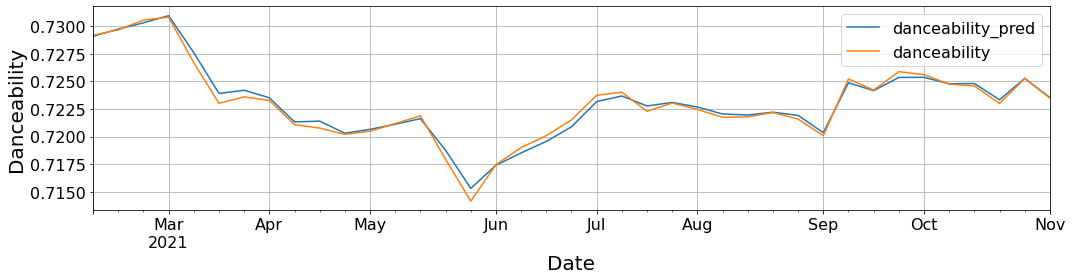

In [52]:
results_df['danceability_pred danceability'.split()].plot(grid=True, figsize=(15,4));
plt.xlabel('Date', fontsize=20)
plt.ylabel('Danceability', fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figs', 'prediction_D_v2.png'))

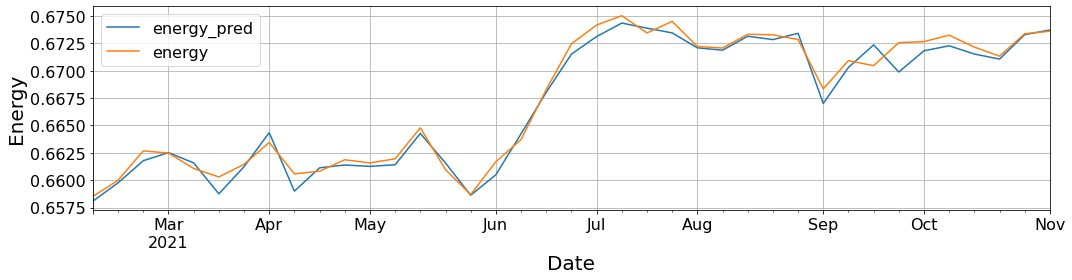

In [53]:
results_df['energy_pred energy'.split()].plot(grid=True, figsize=(15,4));
plt.xlabel('Date', fontsize=20)
plt.ylabel('Energy', fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figs', 'prediction_E_v2.png'))

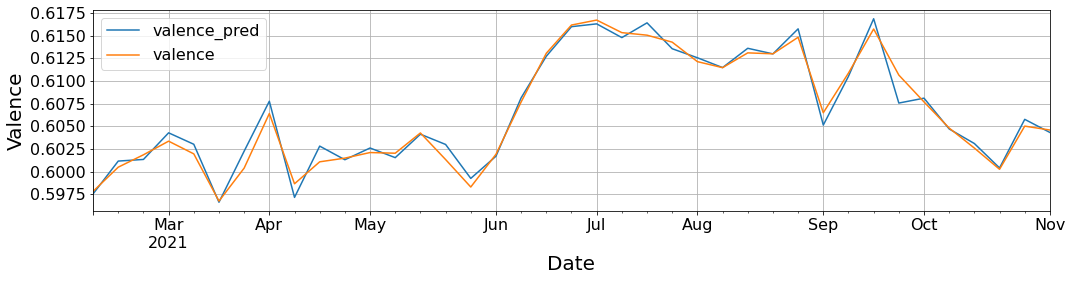

In [54]:
results_df['valence_pred valence'.split()].plot(grid=True, figsize=(15,4));
plt.xlabel('Date', fontsize=20)
plt.ylabel('Valence', fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figs', 'prediction_V_v2.png'))

In [55]:
print("That's all folks!")

That's all folks!
